In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Dependencies to Visualize the model
%matplotlib inline
from IPython.display import Image, SVG
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)


In [3]:
# Filepaths, numpy, and Tensorflow
import os
import cv2
from google.colab import drive
import numpy as np
import tensorflow as tf

In [4]:
# Sklearn scaling
from sklearn.preprocessing import MinMaxScaler

In [5]:
# Keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from io import BytesIO
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, optimizers

In [6]:
drive.mount('/content/drive')

data_directory_path = os.path.join("/content/drive/MyDrive/chest_xray")
train_directory_path = os.path.join(data_directory_path, "train")
train_normal_path = os.path.join(train_directory_path, "NORMAL")
train_pneumonia_path = os.path.join(train_directory_path, "PNEUMONIA")

test_directory_path = os.path.join(data_directory_path, "test")
test_normal_path = os.path.join(test_directory_path, "NORMAL")
test_pneumonia_path = os.path.join(test_directory_path, "PNEUMONIA")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


----- LOADING DATASETS -----

In [7]:
print(len(os.listdir(train_normal_path)))
print(len(os.listdir(train_pneumonia_path)))
print(len(os.listdir(test_normal_path)))
print(len(os.listdir(test_pneumonia_path)))


1362
3903
234
390


In [8]:
X_train = []
y_train = []

X_test = []
y_test = []

In [9]:
for image_file in os.listdir(train_normal_path):
  image_path = os.path.join(train_normal_path, image_file)
  image = cv2.imread(image_path)
  image = cv2.resize(image, (256, 256))
  X_train.append(image)
  y_train.append(0)

In [10]:
for image_file in os.listdir(train_pneumonia_path):
  image_path = os.path.join(train_pneumonia_path, image_file)
  image = cv2.imread(image_path)
  image = cv2.resize(image, (256, 256))
  X_train.append(image)
  y_train.append(1)

In [11]:
for image_file in os.listdir(test_normal_path):
  image_path = os.path.join(test_normal_path, image_file)
  image = cv2.imread(image_path)
  image = cv2.resize(image, (256, 256))
  X_test.append(image)
  y_test.append(0)

In [12]:
for image_file in os.listdir(test_pneumonia_path):
  image_path = os.path.join(test_pneumonia_path, image_file)
  image = cv2.imread(image_path)
  image = cv2.resize(image, (256, 256))
  X_test.append(image)
  y_test.append(1)

In [13]:
# Convert lists to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [14]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5265, 256, 256, 3)
y_train shape: (5265,)
X_test shape: (624, 256, 256, 3)
y_test shape: (624,)


In [15]:
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

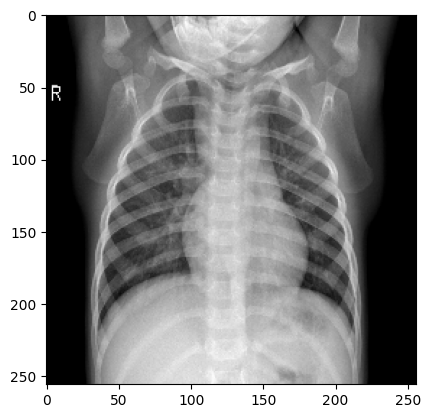

In [16]:
# Plot the first image from the dataset
plt.imshow(X_train[0], cmap=plt.cm.Greys)

----- BUILDING THE MODEL -----


In [17]:

model = models.Sequential([
      Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(1, activation='softmax')  # Output layer with softmax activation for multi-class classification
])

In [18]:
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

In [19]:
# model.fit(
#     X_train,
#     y_train,
#     epochs=10,
#     shuffle=True,
#     verbose=2
# )

In [20]:
# model_loss, model_accuracy = model.evaluate(X_test, y_test, verbose=2)
# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

------- TEST THE MODEL ---------

In [21]:
# test = np.expand_dims(X_train[0], axis=0)
# plt.imshow(scaler.inverse_transform(test).reshape(28, 28), cmap=plt.cm.Greys)
# model.predict(test).round()

In [26]:
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
                                                     min_value=1,
                                                     max_value=10,
                                                     step=2),
                                       activation=activation
                                      ))
    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                         min_value=1,
                                                         max_value=10,
                                                         step=2),
                                           activation=activation))
    nn_model.add(tf.keras.layers.Flatten())
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

    return nn_model

In [27]:
!pip install keras_tuner
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

Reloading Tuner from ./untitled_project/tuner0.json


In [33]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train,y_train,epochs=20,validation_data=(X_test,y_test))

Trial 56 Complete [00h 00m 28s]
val_accuracy: 0.8092948794364929

Best val_accuracy So Far: 0.8429487347602844
Total elapsed time: 01h 13m 38s


In [34]:
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'relu',
 'first_units': 7,
 'num_layers': 2,
 'units_0': 9,
 'units_1': 7,
 'units_2': 3,
 'units_3': 5,
 'units_4': 3,
 'tuner/epochs': 7,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0}

In [36]:
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

20/20 - 1s - loss: 38.9181 - accuracy: 0.8429 - 667ms/epoch - 33ms/step
Loss: 38.918052673339844, Accuracy: 0.8429487347602844
